In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

INTERIM_PATH = "C:/Project/UK store analysis/data/01_interim/cleaned_supermarket_data.parquet"
df = pd.read_parquet(INTERIM_PATH)

print("Cleaned data loaded successfully")
df.head(3)

Cleaned data loaded successfully


,supermarket,prices,prices_unit,unit,names,date,category,own_brand
0,Aldi,3.09,0.14,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 22 Pack/...,2024-04-13,baby_products,False
1,Aldi,3.09,0.17,unit,Mamia Ultra-fit Peppa Pig Nappy Pants 18 Pack/...,2024-04-13,baby_products,False
2,Aldi,3.59,0.09,unit,Mamia Ultra-fit Nappy Pants 40 Pack/Size 4,2024-04-13,baby_products,False


In [4]:
# Identify products sold by multiple retailers
product_counts = df.groupby("names")["supermarket"].nunique()
multi_retailer_products = product_counts[product_counts > 1].index.tolist()

# Filter main dataframe to only include comparable products
df_comp = df[df["names"].isin(multi_retailer_products)].copy()

print(f"Original unique products: {df["names"].nunique()}")
print(f"Products sold at > 1 retailer: {len(multi_retailer_products)}")
print(f"Shape of competitive dataset: {df_comp.shape}")

Original unique products: 127226
Products sold at > 1 retailer: 3303
Shape of competitive dataset: (532722, 8)


## Cross Retailer Price Comparison for Identical Products

In [5]:
# Find min, max and spread of prices for each product on the latest date
latest_date = df_comp["date"].max()
df_latent = df_comp[df_comp["date"] == latest_date]

# Pivot the table to have products as rows and supermarkets as columns
price_pivot = df_latent.pivot_table(index="names", columns="supermarket", values="prices")

# Calculate key competitive metrics
price_pivot["min_price"] = price_pivot.min(axis=1)
price_pivot["max_price"] = price_pivot.max(axis=1)
price_pivot["price_spread"] = price_pivot["max_price"] - price_pivot["min_price"]

# Identify the cheapest retailer for each product
price_pivot["cheapest_supermarket"] = price_pivot.idxmin(axis=1)

print("\nPrice Comparison for latest date: ")
price_pivot.head()


Price Comparison for latest date: 


supermarket,ASDA,Aldi,Morrisons,Sains,Tesco,min_price,max_price,price_spread,cheapest_supermarket
names,,,,,,,,,
19 Crimes Chardonnay,9.5,NaN,9.0,NaN,NaN,9.0,9.50,0.50,price_spread
19 Crimes Red Wine 1.5L,NaN,NaN,NaN,15.50,15.5,15.5,15.50,0.00,price_spread
19 Crimes Sparkling White,12.0,NaN,9.5,NaN,NaN,9.5,12.00,2.50,price_spread
19 Crimes The Uprising Red Wine,8.5,NaN,9.0,NaN,NaN,8.5,9.00,0.50,price_spread
7UP Zero Sugar Lemon & Lime Bottle 500ml,NaN,NaN,NaN,1.75,1.6,1.6,1.75,0.15,price_spread


C:\Users\bharg\AppData\Local\Temp\ipykernel_46764\1385370635.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cheapest_counts.index, y=cheapest_counts.values, palette=color_map)


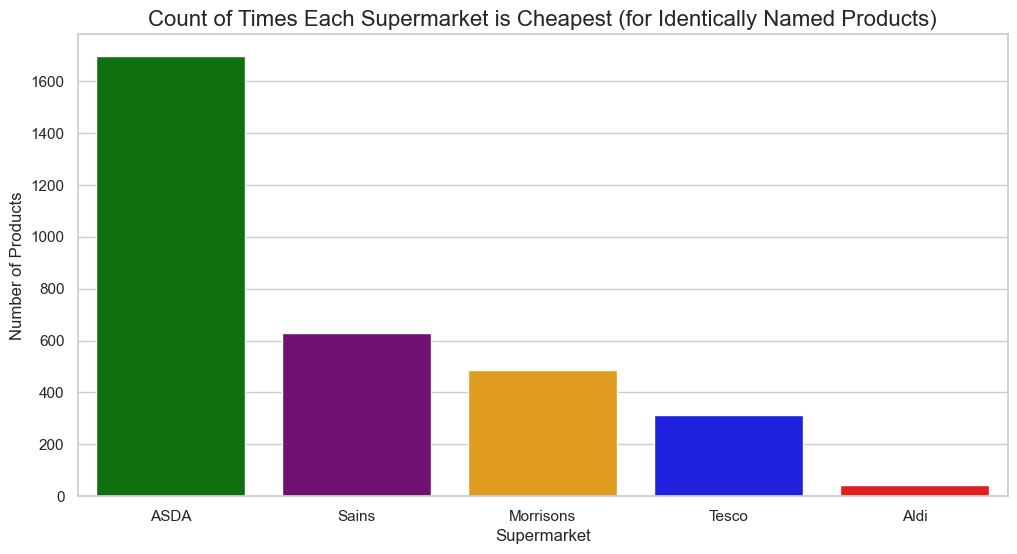

In [ ]:

supermarket_cols = ['ASDA', 'Aldi', 'Morrisons', 'Sains', 'Tesco']

# Now, find the cheapest supermarket by looking ONLY at those columns
price_pivot['cheapest_supermarket'] = price_pivot[supermarket_cols].idxmin(axis=1)

# Recalculate the counts
cheapest_counts = price_pivot['cheapest_supermarket'].value_counts()

plt.figure(figsize=(12, 6))
# Create a color map to ensure Aldi is visually distinct
color_map = {'Aldi': 'red', 'ASDA': 'green', 'Morrisons': 'orange', 'Sains': 'purple', 'Tesco': 'blue'}
sns.barplot(x=cheapest_counts.index, y=cheapest_counts.values, palette=color_map)
plt.title('Count of Times Each Supermarket is Cheapest (for Identically Named Products)', fontsize=16)
plt.xlabel('Supermarket', fontsize=12)
plt.ylabel('Number of Products', fontsize=12)
plt.show()

Limited Comparability: Only around 3,303 out of 127,226 unique products (~2.6%) have perfectly matching names. This is the single biggest limitation of our current analysis. It means we are comparing a tiny, non-random fraction of the total product universe.

## Product Level Deep Dive Dive and Volatility

In [8]:
# Most/Least Competitive Products
# Find products with the largest price spread
top_spread_products = price_pivot.nlargest(10, "price_spread")
print("\nTop 10 Products with the Largest Price Spread: ")
print(top_spread_products[["min_price", "max_price", "price_spread"]])

# Price volatility analysis
# For each product, calculate the standard deviation of its price over time this tells us how much its price fluctuates
volatility = df_comp.groupby("names")["prices"].std().sort_values(ascending=False).dropna()

print("\nTop 10 Most Volatile Products:")
print(volatility.head(10))

print("\nTop 10 Most Stable (Least Volatile) Products: ")
print(volatility.tail(10))


Top 10 Products with the Largest Price Spread: 
supermarket                                         min_price  max_price  \
names                                                                      
Oral-B iO 3 Black Electric Toothbrush                   75.00     160.00   
Benson & Hedges Blue 20 Cigarettes                      13.00      64.75   
Talisker Skye Single Malt Scotch Whisky                 27.00      48.00   
Oral-B Vitality Pro Black & Purple Electric Too...      40.00      60.00   
Braun Beard Trimmer BT3440                              34.66      52.00   
Glenmorangie Lasanta 12 Years Old Single Malt W...      37.50      52.50   
L'Oreal Paris Revitalift Laser Renew Anti Agein...      15.00      30.00   
Hardys Stamp Chardonnay Semillon                         6.00      20.25   
BaByliss Rose Lustre 2400 Hair Dryer                    25.00      38.00   
Budweiser Lager Beer Bottles                             4.75      17.00   

supermarket                           

High-Value Items Drive Spread & Volatility: Lists of top spread/volatility products (electric toothbrushes, cigarettes, whisky, hair straighteners) are dominated by high-ticket, non-essential items. This is where retailers have the most room for deep promotions and price differentiation. The most stable items are often new (LEGOs) or have very consistent RRPs.